## **CNN | Redes neuronales convolucionales**

Usamos el conjunto de datos CIFAR-10 para entrenar un algoritmo de aprendizaje automático. 
El CIFAR-10 consiste en una colección de 10 imágenes diferentes 

In [1]:
#importamos librerías
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#The stars
import tensorflow as tf
from tensorflow import keras

### **Cargamos el dataset**

In [2]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
print(X_train_full.shape,y_train_full.shape,X_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


Vemos que tenemos 60000 imágenes de 32x32 rgb

En Datasets grandes, CrossValidation puede ser muy costoso, por lo cual se recomienda separar un conjunton de validación aparte del training. Esto hacemos a continuación.

También normalizamos los píxeles (que van de 0 a 255) para que estén entre 0 y 1.

In [4]:
#Separo en entrenamiento y validacion, y normalizo los pixeles
X_valid, X_train = X_train_full[:10000] / 255., X_train_full[10000:] / 255.
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]
X_test = X_test / 255.

(50000, 32, 32, 3)


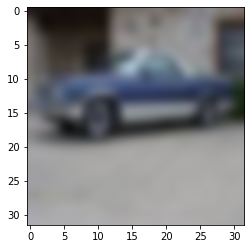

In [5]:
print(X_train_full.shape)

plt.imshow(X_train[0], cmap='binary', interpolation='bicubic')

Los targets son numericos, del 0 al 9. Podemos guardar las etiquetas asi nos es mas facil analizar que tan bien o mal funciona nuestro modelo:

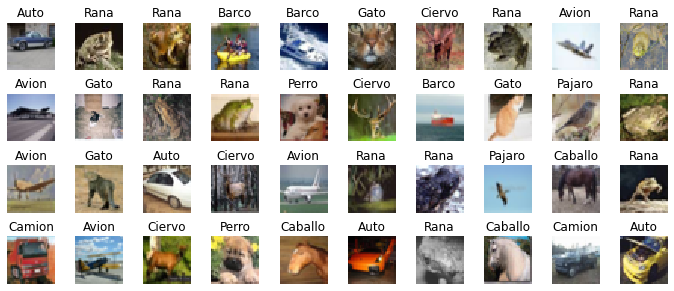

In [6]:
class_names = ["Avion", "Auto", "Pajaro", "Gato","Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camion"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


### **Filtros y Capa Convolucional**
Un filtro es una ventana que posee 0s y 1s en determinados pixeles. Una capa que consiste en un filtro que se mueve por toda la imagen se llama feature map. Los dos filtros "base" son los verticales y horizontales.

Preparo para aplicar al filtro de la CNN

In [7]:
images = X_train[0]
height, width, channels = images.shape

Estos son los filtros (ventana 3,3)

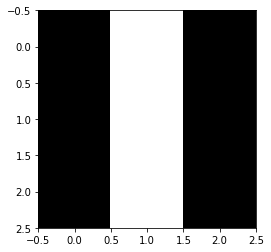

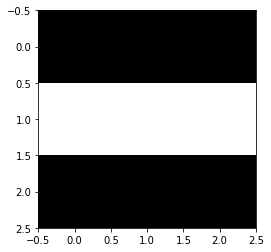

In [8]:
filters = np.zeros(shape=(3, 3, channels, 2), dtype=np.float32)#presten atencion al shape
filters[:, 1, :, 0] = 1  # filtro vertical
filters[1, :, :, 1] = 1  # filtro horizontal
plt.imshow(filters[:, :, 0, 0], cmap="gray", interpolation="nearest")
plt.show()
plt.imshow(filters[:, :, 0, 1], cmap="gray", interpolation="nearest")
plt.show()

Ahora lo aplicamos para ver el resultado (Geron)

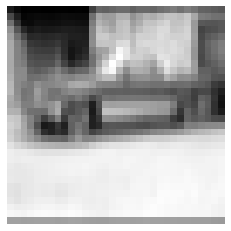

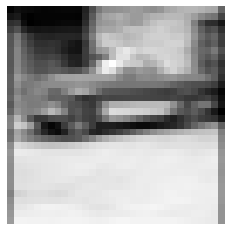

In [9]:
outputs = tf.nn.conv2d(images.reshape(1,height,width,channels), filters, strides=1, padding="SAME")
plt.imshow(outputs[0, :, :, 0], cmap="gray") # Aplico el primer filtro
plt.axis("off") # Not shown in the book
plt.show()
plt.imshow(outputs[0, :, :, 1], cmap="gray") # Aplico el segundo filtro
plt.axis("off") # Not shown in the book
plt.show()

### **Preprocesado**

Preprocesamos las imágenes para mejorar la performance del modelo CNN ya que el dataset es pequeño 

In [10]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

### **API funcional**



In [11]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
input_ = keras.layers.Input(shape=X_train.shape[1:]) #En este caso es necesario definir el Layer de Inputs
conv1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_)
conv2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  padding='valid',activation='relu')(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
dropout1 = keras.layers.Dropout(0.25)(pool1)
flatten = keras.layers.Flatten()(dropout1)
hidden1 = keras.layers.Dense(512, activation="relu")(flatten)
dropout2 = keras.layers.Dropout(0.5)(hidden1)
output = keras.layers.Dense(10, activation="softmax")(dropout2)
model = keras.models.Model(inputs=[input_], outputs=[output])

### **Compilar y visualizar**



In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
early_stopping_cb=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               368691

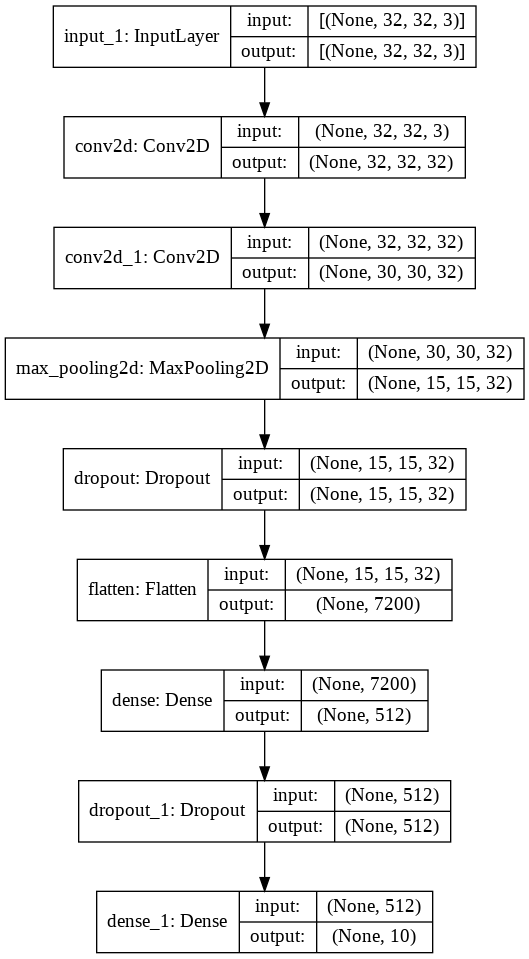

In [15]:
keras.utils.plot_model(model, "my_cifar_cnn.png", show_shapes=True)

### **Entrenar**



In [16]:
history = model.fit_generator(datagen.flow(X_train, y_train[:,0], batch_size = 100), epochs = 20, validation_data=(X_valid, y_valid[:,0]), callbacks=[early_stopping_cb])
 
 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
400/400 [==============================] - 132s 328ms/step - loss: 2.2455 - accuracy: 0.1558 - val_loss: 1.9577 - val_accuracy: 0.3142
Epoch 2/20
400/400 [==============================] - 130s 325ms/step - loss: 1.9908 - accuracy: 0.2786 - val_loss: 1.8210 - val_accuracy: 0.3660
Epoch 3/20
400/400 [==============================] - 130s 325ms/step - loss: 1.8689 - accuracy: 0.3347 - val_loss: 1.7182 - val_accuracy: 0.3994
Epoch 4/20
400/400 [==============================] - 134s 334ms/step - loss: 1.7930 - accuracy: 0.3593 - val_loss: 1.6615 - val_accuracy: 0.4163
Epoch 5/20
400/400 [==============================] - 130s 326ms/step - loss: 1.7308 - accuracy: 0.3828 - val_loss: 1.5768 - val_accuracy: 0.4483
Epoch 6/20
400/400 [==============================] - 131s 326ms/step - loss: 1.6871 - accuracy: 0.3988 - val_loss: 1.5123 - val_accuracy: 0.4630
Epoch 7/20
400/400 [==============================] - 131s 327ms/step - loss: 1.6288 - accuracy: 0.4198 - val_loss: 1.4657 -

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

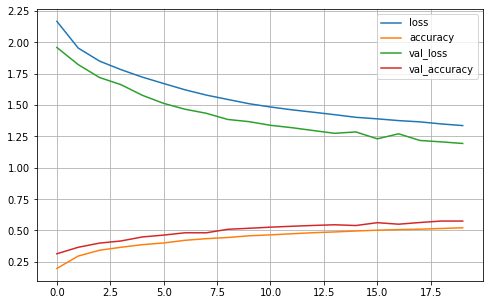

In [18]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

### **Evaluación y predicción**

In [19]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 8s 26ms/step - loss: 1.1944 - accuracy: 0.5754


[1.194375991821289, 0.5753999948501587]

In [29]:
X_new = X_test[:10]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.01, 0.  , 0.06, 0.46, 0.02, 0.39, 0.03, 0.01, 0.01, 0.  ],
       [0.1 , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.02],
       [0.15, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.52, 0.06],
       [0.3 , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.63, 0.01],
       [0.  , 0.  , 0.09, 0.19, 0.4 , 0.08, 0.23, 0.01, 0.  , 0.  ],
       [0.02, 0.01, 0.03, 0.14, 0.03, 0.1 , 0.64, 0.03, 0.  , 0.01],
       [0.08, 0.62, 0.01, 0.11, 0.  , 0.07, 0.01, 0.01, 0.  , 0.09],
       [0.02, 0.  , 0.11, 0.02, 0.08, 0.01, 0.74, 0.01, 0.  , 0.  ],
       [0.01, 0.  , 0.15, 0.32, 0.1 , 0.31, 0.03, 0.08, 0.  , 0.  ],
       [0.  , 0.91, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.08]],
      dtype=float32)

In [30]:
y_pred = np.argmax(y_proba, axis=-1)
y_pred

array([3, 1, 8, 8, 4, 6, 1, 6, 3, 1])

In [31]:
np.array(class_names)[y_pred]

array(['Gato', 'Auto', 'Barco', 'Barco', 'Ciervo', 'Rana', 'Auto', 'Rana',
       'Gato', 'Auto'], dtype='<U7')

### **Veamos las predicciones del modelo**

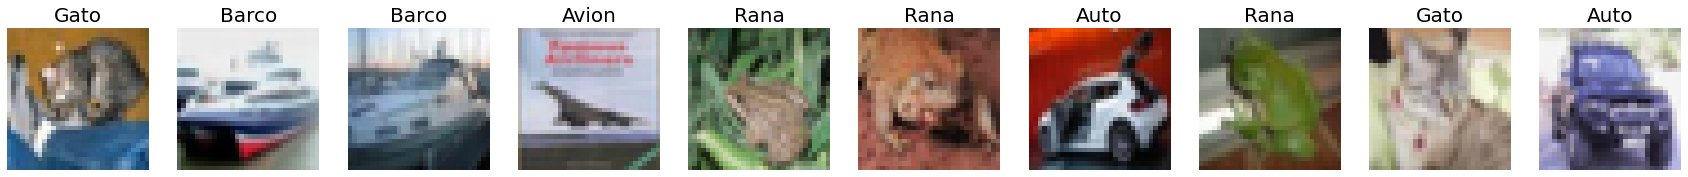

In [39]:

plt.figure(figsize=(30, 30))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index][0]], fontsize=20)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

###  **Guardar y cargar modelos**

In [24]:
#para guardar
model.save("my_keras_model.h5")

In [25]:
#para cargar 
model = keras.models.load_model("my_keras_model.h5")